# Fastai Book further Research

Task is to implement a custom tta function, which takes the 4 corners of the image and the center crop and then averages it to calculate the accuracy of the model. The task is to be performed with the use of the Fastai documentation. 

In [1]:
from fastai.vision.all import *
import fastai

In [2]:
path = untar_data(URLs.IMAGENETTE, archive='D:\FastAi_Data')

In [21]:
dblock = DataBlock(
    blocks = (ImageBlock,CategoryBlock),
    get_items= get_image_files,
    get_y = parent_label,
    item_tfms= Resize(460),
    batch_tfms= aug_transforms(size=224, min_scale=0.75))
dls = dblock.dataloaders(path,bs=64)

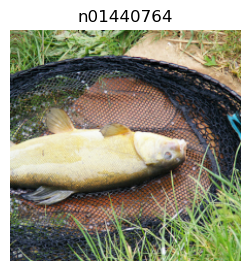

In [22]:
dls.show_batch(max_n=1)

In [16]:
model = xresnet18(n_out = dls.c)
learn = Learner(dls, model, loss_func = CrossEntropyLossFlat(), metrics = accuracy)
learn.fit_one_cycle(5,3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.508342,1.449285,0.531367,04:20
1,1.137820,1.468480,0.550411,04:27
2,0.894963,0.845812,0.730396,04:30
3,0.681035,0.642395,0.797237,05:22
4,0.592215,0.568355,0.818895,10:32


In [9]:
learn_resnet = Learner(dls, resnet50, metrics = accuracy, pretrained = False)

10

In [34]:
preds,targs = learn.tta()
accuracy(preds, targs).item()

0.8289768695831299

In [5]:
class CornerAndCenterCrop(Transform):
    def __init__(self, size, corner = 0, **kwargs):
        self.size = size
        self.corner = corner
    
    def encodes(self, x:(Image.Image,TensorBBox,TensorPoint)):
        self.w, self.h = x.size
        
        left = self.w- self.size
        top = self.h- self.size
        right = self.w
        bottom = self.h
        
        self.crops = [
            x.crop((0, 0, self.size, self.size)), ## top-left
            x.crop((left, 0, right, self.size)), ## top-right
            x.crop((0, top, self.size,bottom)), ## bottom-left
            x.crop((left, top, right,bottom)), ## bottom-right
            x.crop(((self.w/2)-self.size/2, self.h/2 - self.size/2,   ## Center
                      (self.w/2)+self.size/2, self.h/2 + self.size/2 )),
        ]
        
        return self.crops[self.corner]

In [13]:
dblock_test = DataBlock(
    blocks = (ImageBlock,CategoryBlock),
    get_items = get_image_files,
    get_y = parent_label,
    item_tfms=CornerAndCenterCrop(164,0)
)

dls_test = dblock_test.dataloaders(path,bs=64)

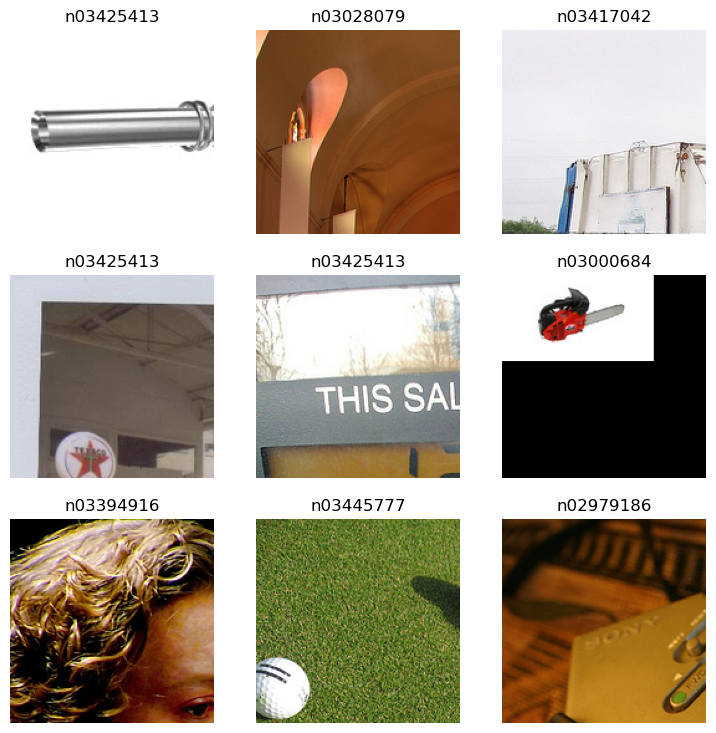

In [14]:
dls_test.show_batch()

In [18]:
class Learner2(Learner):
    def corner_center_crop_tta(self:Learner, ds_idx=1, dl=None, n=4, beta=0.25, use_max=False):
      "Return predictions on the `ds_idx` dataset or `dl` using Corner Crop Test Time Augmentation"
      if dl is None: dl = self.dls[ds_idx].new(shuffled=False, drop_last=False)
      # if item_tfms is not None or batch_tfms is not None: dl = dl.new(after_item=item_tfms, after_batch=batch_tfms)
      try:
          #self(_before_epoch)
          with dl.dataset.set_split_idx(0), self.no_mbar():
              if hasattr(self,'progress'): self.progress.mbar = master_bar(list(range(n)))
              aug_preds = []
              # Crop image from four corners
              for i in self.progress.mbar if hasattr(self,'progress') else range(n):
                  dl = dl.new(after_item=[CornerAndCenterCrop(164,i), ToTensor])
                  self.epoch = i #To keep track of progress on mbar since the progress callback will use self.epoch
                  aug_preds.append(self.get_preds(dl=dl, inner=True)[0][None])
          aug_preds = torch.cat(aug_preds)
          aug_preds = aug_preds.max(0)[0] if use_max else aug_preds.mean(0)
          self.epoch = n
          with dl.dataset.set_split_idx(1): preds,targs = self.get_preds(dl=dl, inner=True)
      finally: self(event.after_fit)

      if use_max: return torch.stack([preds, aug_preds], 0).max(0)[0],targs
      preds = (aug_preds,preds) if beta is None else torch.lerp(aug_preds, preds, beta)
      return preds,targs

In [23]:
model = xse_resnet18()
learn = Learner2(dls, model, loss_func= CrossEntropyLossFlat(), metrics = accuracy)
learn.fit_one_cycle(5,3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.722431,2.834519,0.286781,06:22
1,1.166220,1.139473,0.638163,06:21
2,0.882387,0.857973,0.719940,06:26
3,0.702823,0.612860,0.802091,06:23
4,0.571099,0.534564,0.827483,06:22


In [24]:
preds,targs = learn.tta()
accuracy(preds, targs).item()

0.8398058414459229

In [25]:
preds,targs = learn.corner_center_crop_tta(n=5)
accuracy(preds, targs).item()

0.5944734811782837

## Conclusion
As we can see the tta implementation by fastai gives us a better accuracy than the custom one that we implemented